In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

df = pd.read_csv("/content/drive/MyDrive/世界モデル_最終課題/timeseries.csv")

ID_COL = "patient_id"
TIME_COL = "time_days"

feature_cols = [
    c for c in df.columns
    if c not in [ID_COL, TIME_COL]
    and not c.startswith("met_")
    and not c.startswith("tx_")
]

F = len(feature_cols)
print("num features:", F)

scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

def make_triples(df):
    """
    (x_t, x_{t+1}) でグラフを作って x_{t+2} を予測するためのサンプルを作る
    """
    triples = []
    for pid, g in df.groupby(ID_COL):
        g = g.sort_values(TIME_COL)
        x = g[feature_cols].values
        t = g[TIME_COL].values

        # t, t+1, t+2 が必要なので -2 まで
        for i in range(len(g) - 2):
            triples.append({
                "pid": pid,
                "x_t": x[i],
                "x_tp1": x[i+1],
                "x_tp2": x[i+2],
                "dt01": float(t[i+1] - t[i]),
                "dt12": float(t[i+2] - t[i+1]),
            })
    return triples

triples = make_triples(df)
print("num triples:", len(triples))

import torch.nn as nn
import torch.nn.functional as torch_F

class CrossTimeAttention(nn.Module):
    def __init__(self, in_dim, attn_dim):
        super().__init__()
        self.q = nn.Linear(in_dim, attn_dim, bias=False)
        self.k = nn.Linear(in_dim, attn_dim, bias=False)

    def forward(self, x_t, x_tp1):
        """
        x_t, x_tp1: (F, in_dim)
        """
        Q = self.q(x_t)
        K = self.k(x_tp1)
        A = Q @ K.T / np.sqrt(Q.size(-1))
        return torch_F.softmax(A, dim=1)  # row-wise

!pip -q install torch-geometric

from torch_geometric.nn import GCNConv, dense_diff_pool

class DiffPoolItemNet(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_clusters):
        super().__init__()
        self.gnn_embed = GCNConv(in_dim, hidden_dim)
        self.gnn_pool  = GCNConv(in_dim, num_clusters)

    def forward(self, x, adj):
        # dense adj -> edge_index/edge_weight
        edge_index = adj.nonzero().T
        edge_weight = adj[edge_index[0], edge_index[1]]

        z = self.gnn_embed(x, edge_index, edge_weight)
        s = self.gnn_pool(x, edge_index, edge_weight)

        x_pool, adj_pool, _, _ = dense_diff_pool(
            z.unsqueeze(0),
            adj.unsqueeze(0),
            s.unsqueeze(0)
        )
        return x_pool.squeeze(0), adj_pool.squeeze(0), s

device: cuda
num features: 42
num triples: 123742


In [3]:
class ItemGraphEncoder(nn.Module):
    def __init__(self, num_clusters, F_features):
        super().__init__()
        self.F_features = F_features
        self.attn = CrossTimeAttention(1, 16)
        self.diffpool = DiffPoolItemNet(4, 16, num_clusters) # Reduced hidden_dim from 32 to 16
        self.latent_dim = num_clusters * 16   # Adjusted latent_dim accordingly

    def forward(self, triple):
        x_t   = torch.tensor(triple["x_t"],   dtype=torch.float, device=device)
        x_tp1 = torch.tensor(triple["x_tp1"], dtype=torch.float, device=device)
        dt01  = torch.tensor(triple["dt01"],  dtype=torch.float, device=device)

        A = self.attn(x_t.unsqueeze(1), x_tp1.unsqueeze(1))

        H = torch.stack([
            x_t,
            x_tp1,
            x_tp1 - x_t,
            torch.ones(self.F_features, device=device) * dt01,
        ], dim=1)

        x_pool, _, S = self.diffpool(H, A)
        z = x_pool.flatten()   # ← ここが GRU に入る
        return z, S

In [4]:
class TemporalSmoother(nn.Module):
    def __init__(self, dim, kernel_size=5):
        super().__init__()
        assert kernel_size % 2 == 1
        self.conv = nn.Conv1d(
            dim, dim,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            groups=dim,
            bias=False
        )
        nn.init.constant_(self.conv.weight, 1.0 / kernel_size)

    def forward(self, z_seq):
        # z_seq: (1, T, D)
        x = z_seq.transpose(1, 2)
        x = self.conv(x)
        return x.transpose(1, 2)


In [5]:
class WindowTransformer(nn.Module):
    def __init__(self, dim, heads=2, max_len=512):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            dim, heads, batch_first=True
        )
        self.ln = nn.LayerNorm(dim)

        # ★ 追加
        self.pos_emb = nn.Embedding(max_len, dim)

    def forward(self, x):
        # x: (1, W, D)
        W = x.size(1)
        pos = torch.arange(W, device=x.device)
        pos = self.pos_emb(pos).unsqueeze(0)  # (1, W, D)

        x = x + pos   # ★ 位置情報を足す

        out, attn_w = self.attn(x, x, x, need_weights=True)
        return self.ln(x + out), attn_w



In [6]:
class StateDiffPool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.embed = GCNConv(dim, dim)
        self.pool  = GCNConv(dim, 2)  # ← 状態0/1

    def forward(self, h, A):
        # h: (W, D), A: (W, W)
        edge_index = A.nonzero().T
        edge_weight = A[edge_index[0], edge_index[1]]

        z = self.embed(h, edge_index, edge_weight)
        s = self.pool(h, edge_index, edge_weight)

        h_pool, _, _, _ = dense_diff_pool(
            z.unsqueeze(0),
            A.unsqueeze(0),
            s.unsqueeze(0)
        )
        return h_pool.squeeze(0), s


In [7]:
from collections import defaultdict

triples_by_pid = defaultdict(list)
for tr in triples:
    triples_by_pid[tr["pid"]].append(tr)

In [8]:
class TimeFFN(nn.Module):
    def __init__(self, dim, hidden_mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * hidden_mult),
            nn.ReLU(),
            nn.Linear(dim * hidden_mult, dim),
        )
        self.ln = nn.LayerNorm(dim)

    def forward(self, x):
        # x: (1, T, D)
        return self.ln(x + self.net(x))

class TimePredictor(nn.Module):
    def __init__(self, dim, out_dim):
        super().__init__()
        self.head = nn.Linear(dim, out_dim)

    def forward(self, h_time):
        """
        h_time: (1, T, D)
        ここでは「最新時刻」を使う
        """
        h_last = h_time[:, -1, :]   # (1, D)
        return self.head(h_last)


In [9]:
encoder   = ItemGraphEncoder(num_clusters=3, F_features=F).to(device)
smoother  = TemporalSmoother(encoder.latent_dim).to(device)
wtrans    = WindowTransformer(encoder.latent_dim).to(device)
time_ffn  = TimeFFN(encoder.latent_dim).to(device)
predictor = TimePredictor(encoder.latent_dim, F).to(device)

optimizer = torch.optim.Adam(
    list(encoder.parameters())
    + list(smoother.parameters())
    + list(wtrans.parameters())
    + list(time_ffn.parameters())
    + list(predictor.parameters()),
    lr=1e-3
)


In [10]:
num_epochs = 10

for epoch in range(num_epochs):
    encoder.train()
    smoother.train()
    wtrans.train()
    time_ffn.train()
    predictor.train()

    total_epoch_loss = 0.0
    n_pred_epoch = 0

    for pid, patient_triples in triples_by_pid.items():
        if len(patient_triples) < 2:
            continue

        # 潜在系列 z_t
        z_list = []
        for tr in patient_triples:
            z, _ = encoder(tr)
            z_list.append(z)
        z_seq = torch.stack(z_list).unsqueeze(0)  # (1, T, D)

        patient_loss = 0.0
        n_pred_patient = 0

        for t in range(1, len(patient_triples)):
            z_hist = z_seq[:, :t+1]   # (1, T, D)

            # (1) 平滑
            z_s = smoother(z_hist)

            # (2) 時間 attention
            h_time, attn = wtrans(z_s)   # (1, T, D)

            # (3) FFN
            h_time = time_ffn(h_time)    # (1, T, D)

            # (4) 予測
            pred = predictor(h_time)

            target = torch.tensor(
                patient_triples[t]["x_tp2"],
                dtype=torch.float,
                device=device
            )

            loss = torch_F.mse_loss(pred, target)
            patient_loss += loss
            n_pred_patient += 1

        if n_pred_patient > 0:
            patient_loss = patient_loss / n_pred_patient
            optimizer.zero_grad()
            patient_loss.backward()
            optimizer.step()

            total_epoch_loss += patient_loss.item() * n_pred_patient
            n_pred_epoch += n_pred_patient

    avg_epoch_loss = total_epoch_loss / max(1, n_pred_epoch)
    print(f"epoch {epoch}: loss={avg_epoch_loss:.4f}")


/tmp/ipython-input-778864155.py:48: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([1, 42])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch_F.mse_loss(pred, target)


epoch 0: loss=0.9800
epoch 1: loss=0.8668
epoch 2: loss=0.8088
epoch 3: loss=0.7803
epoch 4: loss=0.7533
epoch 5: loss=0.7466
epoch 6: loss=0.7373
epoch 7: loss=0.7289
epoch 8: loss=0.7230
epoch 9: loss=0.7188


In [11]:
target_pid = 1001
pid = target_pid
patient_triples = triples_by_pid[pid]

encoder.eval()
smoother.eval()
wtrans.eval()
time_ffn.eval()
predictor.eval()

with torch.no_grad():
    z_list = []
    for tr in patient_triples:
        z, _ = encoder(tr)
        z_list.append(z)
    z_seq = torch.stack(z_list).unsqueeze(0)

    z_s = smoother(z_seq)
    h_time, attn = wtrans(z_s)
    h_time = time_ffn(h_time)

In [12]:
with torch.no_grad():
    _, S = encoder(patient_triples[0])

S = S.softmax(dim=1).cpu().numpy()

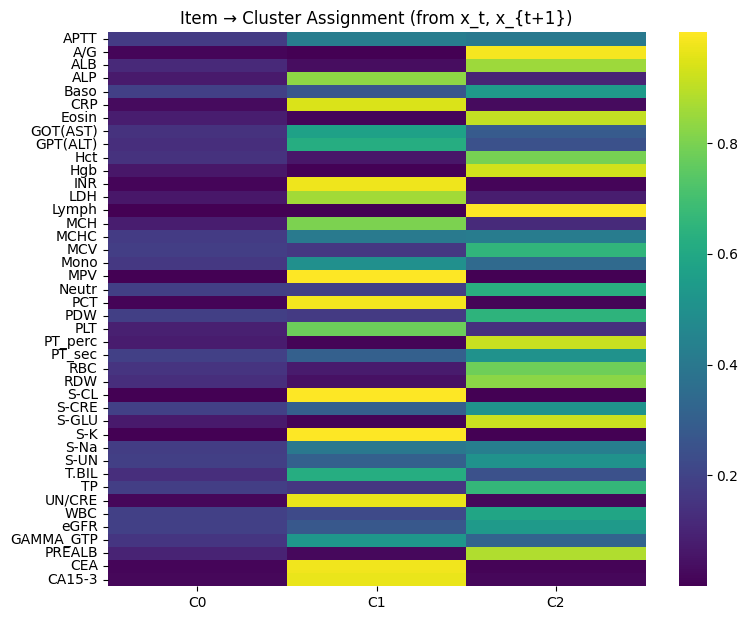

In [13]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, max(4, F*0.15)))
sns.heatmap(
    S, cmap="viridis",
    yticklabels=feature_cols,
    xticklabels=[f"C{k}" for k in range(S.shape[1])]
)
plt.title("Item → Cluster Assignment (from x_t, x_{t+1})")
plt.tight_layout()
plt.show()


In [14]:
def compute_attention_distance(attn):
    """
    attn: (1, heads, T, T)  or  (heads, T, T)
    return: (T,)  各時刻の参照距離
    """
    if attn.dim() == 4:
        A = attn.mean(dim=1).squeeze(0)  # (T, T)
    else:
        A = attn.mean(dim=0)              # (T, T)

    T = A.size(0)
    idx = torch.arange(T, device=A.device)
    dist = (A * (idx[None, :] - idx[:, None]).abs()).sum(dim=1)
    return dist.detach().cpu().numpy()

def compute_latent_speed(z_seq):
    """
    z_seq: (1, T, D)
    return: (T-1,)
    """
    dz = z_seq[:, 1:] - z_seq[:, :-1]
    speed = dz.norm(dim=-1).squeeze(0)
    return speed.detach().cpu().numpy()


In [15]:
import matplotlib.pyplot as plt

target_pid = 1001
patient_triples = triples_by_pid[target_pid]

encoder.eval()
smoother.eval()
wtrans.eval()
time_ffn.eval()

with torch.no_grad():
    # 潜在列 z_t
    z_list = []
    for tr in patient_triples:
        z, _ = encoder(tr)
        z_list.append(z)
    z_seq = torch.stack(z_list).unsqueeze(0)  # (1, T, D)

    # 平滑
    z_s = smoother(z_seq)

    # 時間 attention
    h_time, attn = wtrans(z_s)

    # ④ 参照距離
    attn_dist = compute_attention_distance(attn)

    # ⑤ 潜在変化率
    latent_speed = compute_latent_speed(z_s)


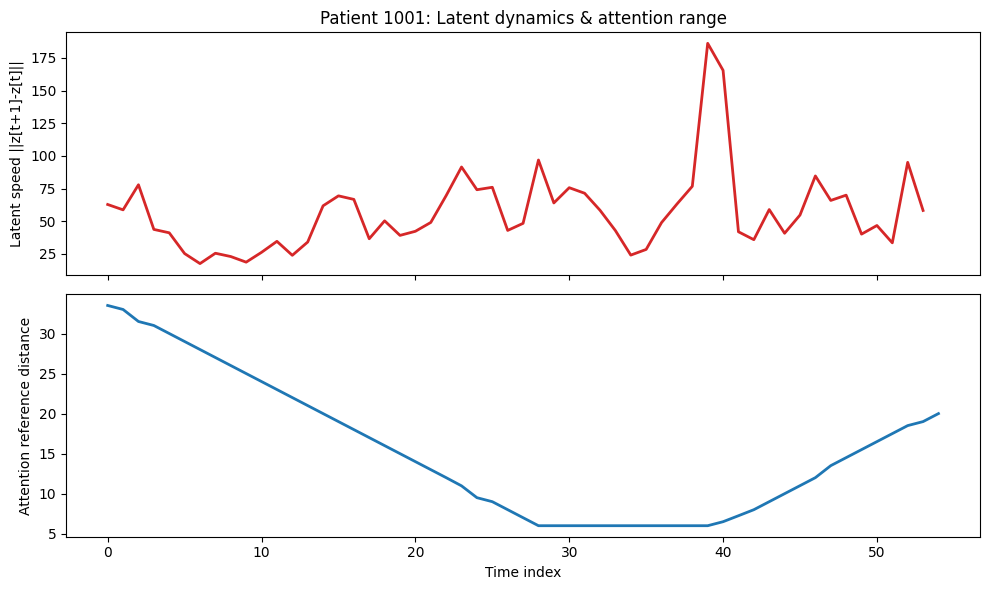

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# --- 上：潜在変化率 ---
axes[0].plot(latent_speed, color="tab:red", lw=2)
axes[0].set_ylabel("Latent speed ||z[t+1]-z[t]||")
axes[0].set_title(f"Patient {target_pid}: Latent dynamics & attention range")

# --- 下：参照距離 ---
axes[1].plot(attn_dist, color="tab:blue", lw=2)
axes[1].set_ylabel("Attention reference distance")
axes[1].set_xlabel("Time index")

plt.tight_layout()
plt.show()